# Multiple-layer neural network 

A neural network system with multiple hidden layers for binary classification

1. Prepare all helper functions

a. Sigmoid 

In [1]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

b. Relu (Rectified Linear Unit)

In [2]:
def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    cache = Z 
    return A, cache

c. Sigmoid back

In [3]:
def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """

    Z = cache

    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)

    return dZ

d. Relu back

In [4]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    return dZ

2. Initialize required parameters (weights, bais)

In [5]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

3. Forward propagation

In this section, the forward propagation functions will be initialized.

a. Linear Forward
$Z^l = W^lA^{l-1}+b^l$

In [6]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = W.dot(A) + b

    cache = (A, W, b)
    
    return Z, cache

b. Linear -> activation

$Z^l = W^lA^{[l-1]} + b \rightarrow A^l = \sigma(Z^l) $

In [7]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)

    return A, cache

c. forward propagation for all layers

In [8]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)

            
    return AL, caches

4. Compute the cross-entropy cost 

$J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right))$$


In [9]:
def compute_cost(AL, Y):
    
    """
    Argument:

    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)
    
    Return:
    
    cost -- cross-entropy cost

    """
    m = Y.shape[1]
    
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    
    return cost

7. Linear backward

a. Backward Linear 
 * Forward linear =   $Z = WA+ b$
 
 * Backward Linear = $ \frac{\partial J}{ \partial W^{[l]}}, \frac{\partial J}{ \partial A^{[l-1]}}, \frac{\partial J}{ \partial b{[l]}}$

In [10]:
def linear_backward(dZ, cache):
    
    #important three equation
    # dJ/dW2 = dJ/dZ2 . dZ/dW2
    # dJ/db2 = dJ/dZ2 . dZ/db1
    # dJ/dA1 = dJ/dZ2 . dZ/dW2
    
    """
    Argument:
    dZ: derviative of Z of current layer
    cache: A Python tuple contains the current layer's A_prev, weights, and b. 
    
    return: 
    derivative of current layer weights and bais, and previous layer dA 

    """
    A_prev, W, b = cache

    m = A_prev.shape[1]  # number of example

    dW = 1./m * np.dot(dZ, A_prev.T)
    db = 1./m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

b. Linear_activation_back

compute $\frac{\partial J}{\partial Z}$ to use for compute linear backward


In [11]:
def linear_activation_backward(dA, cache, activation):

    # dJ/dZ = dJ/dA . dA/dZ --- then used dZ to compute dA previous, dw current, db current.
    """
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b

    """

    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    if activation == 'sigmoid':

        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

c. Backward propagation for all layers

In [12]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    ### START CODE HERE ### (1 line of code)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    ### END CODE HERE ###
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    ### START CODE HERE ### (approx. 2 lines)
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    ### END CODE HERE ###
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 2)], caches". Outputs: "grads["dA" + str(l + 1)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        ### START CODE HERE ### (approx. 5 lines)
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)],  current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        ### END CODE HERE ###

    return grads

8. update parameters (weights and bais)

In [13]:
def update_parameters(parmeters, grads, learning_rate):
    """
    Argument:
    parameters: a python dictionary containing weights and bais of all layers
    grads: a Python dictionary containing derivatives of weights and bases of all layers

    Return:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...

    """
    

    L = len(parmeters)//2
    
    for l in range(L):
        parmeters["W"+str(l+1)] = parmeters["W"+str(l+1)] - learning_rate * grads["dW"+str(l+1)] 
        parmeters["b"+str(l+1)] = parmeters["b"+str(l+1)] - learning_rate * grads["db"+str(l+1)]
    
    return parmeters

11. calculate the acurracy 

In [14]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p


In [15]:
layers_dims = [12288, 20, 7, 5, 1]

In [16]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    #(≈ 1 line of code)
    # parameters = ...
    # YOUR CODE STARTS HERE
    parameters = initialize_parameters_deep(layers_dims)
    
    # YOUR CODE ENDS HERE
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        #(≈ 1 line of code)
        # AL, caches = ...
        # YOUR CODE STARTS HERE
        AL, caches = L_model_forward(X, parameters)
        
        # YOUR CODE ENDS HERE
        
        # Compute cost.
        #(≈ 1 line of code)
        # cost = ...
        # YOUR CODE STARTS HERE
        cost = compute_cost(AL, Y)
        
        # YOUR CODE ENDS HERE
    
        # Backward propagation.
        #(≈ 1 line of code)
        # grads = ...    
        # YOUR CODE STARTS HERE
        grads = L_model_backward(AL, Y, caches)
        
        # YOUR CODE ENDS HERE
 
        # Update parameters.
        #(≈ 1 line of code)
        # parameters = ...
        # YOUR CODE STARTS HERE
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # YOUR CODE ENDS HERE
                
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

In [17]:
import numpy as np
import h5py
    
def load_dataset():
    
    # load the training data from train_catvnoncat.h5 file
    
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    # load the test data from test_catvnoncat.h5 file
    
    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    # train_set_y_orig.shape = (209,)
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    # train_set_y_orig.shape = (1,209)
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [18]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

num_of_sample, width_of_image, heigh_of_image, channel = train_set_x_orig.shape

# Convert (209, 64, 64, 3) to (209, 12288)
train_set_x_flatten = train_set_x_orig.reshape(num_of_sample, width_of_image*heigh_of_image*channel)

# Convert (209, 12288) to (12288, 209) and normalization
train_set_x = train_set_x_flatten.T / 255.

In [19]:
parameters, costs = L_layer_model(train_set_x, train_set_y, layers_dims, num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6720534400822914
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101354
Cost after iteration 400: 0.5670473268366111
Cost after iteration 500: 0.54013766345478
Cost after iteration 600: 0.5279299569455267
Cost after iteration 700: 0.4654773771766851
Cost after iteration 800: 0.3691258524959279
Cost after iteration 900: 0.39174697434805344
Cost after iteration 1000: 0.3151869888600617
Cost after iteration 1100: 0.2726998441789385
Cost after iteration 1200: 0.23741853400268137
Cost after iteration 1300: 0.19960120532208647
Cost after iteration 1400: 0.18926300388463305
Cost after iteration 1500: 0.1611885466582775
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.13777487812972944
Cost after iteration 1800: 0.1297401754919012
Cost after iteration 1900: 0.12122535068005211
Cost after iteration 2000: 0.1138206066863371
Cost after iteration 2100: 0.107839285262

In [21]:
training_examples_accuracy = predict(train_set_x, train_set_y, parameters)

Accuracy: 0.9856459330143539


In [22]:
num_of_sample, width_of_image, heigh_of_image, channel = test_set_x_orig.shape

# Convert (50, 64, 64, 3) to (50, 12288)
test_set_x_orig_flatten = test_set_x_orig.reshape(num_of_sample, width_of_image*heigh_of_image*channel)

# Convert (50, 12288) to (12288, 50) and normalization 
test_set_x = test_set_x_orig_flatten.T / 255.

In [24]:
training_examples_accuracy = predict(test_set_x, test_set_y, parameters)

Accuracy: 0.8


Accuracy: 1.0
The image dose not contain a cat


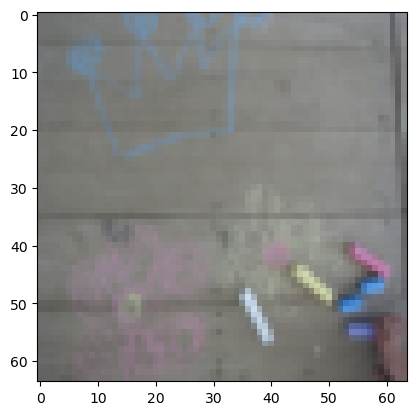

In [65]:
# The system accepts only shapes in the form of (112288, for example).
# As a result, the single example must be converted to (number of features , number of examples). 

import random
index = random.randint(0, 208)

import matplotlib.pyplot as plt
plt.imshow(train_set_x_orig[index])

image = train_set_x[:, index].reshape(-1, 1)
image_y = train_set_y[:, index].reshape(-1, 1)

im = predict(image, image_y, parameters)

if image_y[0][0] == 1:
    if image_y[0][0] == int(im[0][0]):
        print("The image contains a cat")
    else:
        print("The image dose not contain a cat")
        
else: 
    if image_y[0][0] == int(im[0][0]):
        print("The image dose not contain a cat")
    else:
        print("The image dose  contains a cat")
    
# else:
#     if image_y[0][0] == int(im[0][0]):
#         print("The image dose not contain a cat")
#     else:
#         print("The image dose not contain a cat")
        
        
        
# print(image_y[0][0])
# print(int(im[0][0]))

    

# print(train_set_y.shape)